In [1]:
# imports | pytorch
import torch
from PIL import Image
from torch import nn, save, load
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

In [2]:
# imports
import cv2
import imghdr
import os
import numpy as np

In [3]:
# data directory
data_dir = 'data' 
# Valid image extensions
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [4]:
# data cleanup
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [5]:
# Define the transform to resize the images and convert them to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [6]:
# loading images to datasets
# datasets automatically picks up the classes based on folder structure
# 0 -- Helmet off
# 1 -- Helmet on
data = datasets.ImageFolder('./data', transform=transform)

In [7]:
# Data split
# train 80%
training_size = int(len(data)*.8)
# test 20 %
test_size = int(len(data)*.2)

training_size, test_size

(348, 87)

In [8]:
# Dataset split
training_data, test_data = random_split(data, [training_size, test_size])
len(training_data), len(test_data)

(348, 87)

In [9]:
# Batch size
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [10]:
# X.shape == 32 {batch}, 3 {color channels} , 256 x 256 {image size}
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 256, 256])
Shape of y: torch.Size([32]) torch.int64


In [11]:
# Device selection {GPU is available}
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device

'cuda'

In [12]:
# Define Neural Network (model)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*(256-6)*(256-6), 2)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# Instance of the neural newtor, loss, optimizer = Adam
clf = NeuralNetwork().to(device)
opt = torch.optim.Adam(clf.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [22]:
# Training method
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
# Testing method
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
# Training process over 10 epochs
epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n----------------------------------------')
    train(train_dataloader, clf, loss_fn, opt)
    test(test_dataloader, clf, loss_fn)

print("Done!")

Epoch 1
----------------------------------------
loss: 0.025978  [   32/  348]
Test Error: 
 Accuracy: 73.6%, Avg loss: 0.728769 

Epoch 2
----------------------------------------
loss: 0.143751  [   32/  348]
Test Error: 
 Accuracy: 71.3%, Avg loss: 0.817579 

Epoch 3
----------------------------------------
loss: 0.268211  [   32/  348]
Test Error: 
 Accuracy: 71.3%, Avg loss: 0.680228 

Epoch 4
----------------------------------------
loss: 0.061583  [   32/  348]
Test Error: 
 Accuracy: 71.3%, Avg loss: 0.918891 

Epoch 5
----------------------------------------
loss: 0.021343  [   32/  348]
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.752861 

Epoch 6
----------------------------------------
loss: 0.151073  [   32/  348]
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.762127 

Epoch 7
----------------------------------------
loss: 0.008110  [   32/  348]
Test Error: 
 Accuracy: 70.1%, Avg loss: 1.177719 

Epoch 8
----------------------------------------
loss: 0.118063  [   32/  348]
Test

In [17]:
# Saving the model
with open('model_state.pth', 'wb') as f:
    save(clf.state_dict(), f)

In [18]:
# Loading the model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('model_state.pth'))

<All keys matched successfully>

In [19]:
# Setup for manual (User) testing
image = Image.open('images.jpeg')
image_resize = image.resize((256, 256), Image.Resampling.LANCZOS)
image_tensor = ToTensor()(image_resize).unsqueeze(0).to(device)
image_tensor.shape

torch.Size([1, 3, 256, 256])

In [20]:
# Running the model
# 0 -- Helmet off
# 1 -- Helmet on
val = torch.argmax(clf(image_tensor)).item()

if val == 0:
    print('Helmet off')
else:
    print('Helmet on')

Helmet off


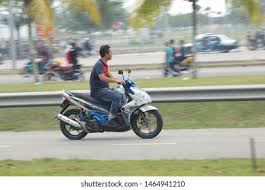

In [21]:
image